# Telco Project

## Project planning
- acquire Telco data via acquire.py file
- clean and prepare data via prepare.py file 
- define the hypothesis, set TP, TN, FP, FN
- establish baseline accuracy
- train classification models 
- choose the best performing model
- document conclusions

In [1]:
import warnings
warnings.filterwarnings("ignore")


#calculations
import numpy as np
import pandas as pd 
from scipy import stats


#dataset
from pydataset import data
import os

#sklearn stuff 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

#graphing
import matplotlib.pyplot as plt
import seaborn as sns

#acquire and prepare data
import acquire 
import prepare
import wrangle

# PLAN

# Acquire and Prepare the Data using Wrangle function

### To acquire the data, we will call from the telco_churn db

### To prepare the data we need to:
 - drop the columns that aren't necessary or that are redundant
 - fix the total charges columns to something that we can work with
 - create dummy variables to more easily deal with the the data during the machine learning portion, in general, columns that have an object dtype will need to be encoded to 1s and 0s
 - concatenate the dummy variables df to our current df
 - create a column that will bin the tenure by intervals of 5 months
 - divide the data into train, test, validate

In [2]:
# we will set wrangle to train, test, validate. 
# This function will acquire our data, prepare it (taking care of any null values in the process), and bring it back in train, test, validate format

train, test, validate = prepare.wrangle_telco()


In [3]:
print(train.shape, validate.shape, test.shape)

(4500, 46) (1407, 46) (1125, 46)


In [4]:
# Stratify with churn
X_train = train.drop(columns=["churn"])
y_train = train.churn

X_validate = validate.drop(columns=["churn"])
y_validate = validate.churn

X_test = test.drop(columns=["churn"])
y_test = test.churn


# Explore


What are some of the factors that could be driving customers to churn?

In [5]:
# first, let's see how many people have churned in the train data set
train.churn.value_counts()

No     3304
Yes    1196
Name: churn, dtype: int64

In [6]:
churn_rate = train.churn_Yes.mean()
print('The churn rate of the train data was' , round(churn_rate,4) *100 , 'percent', '%')

The churn rate of the train data was 26.58 percent %


Takeaway: about 27% of customers are churning
 - find potential common traits of people who are churning

### Now we will look at a few different variables to see what possible traits that people who are churning could share.
- the red line on the graphs represents the average churn rate of 27% 

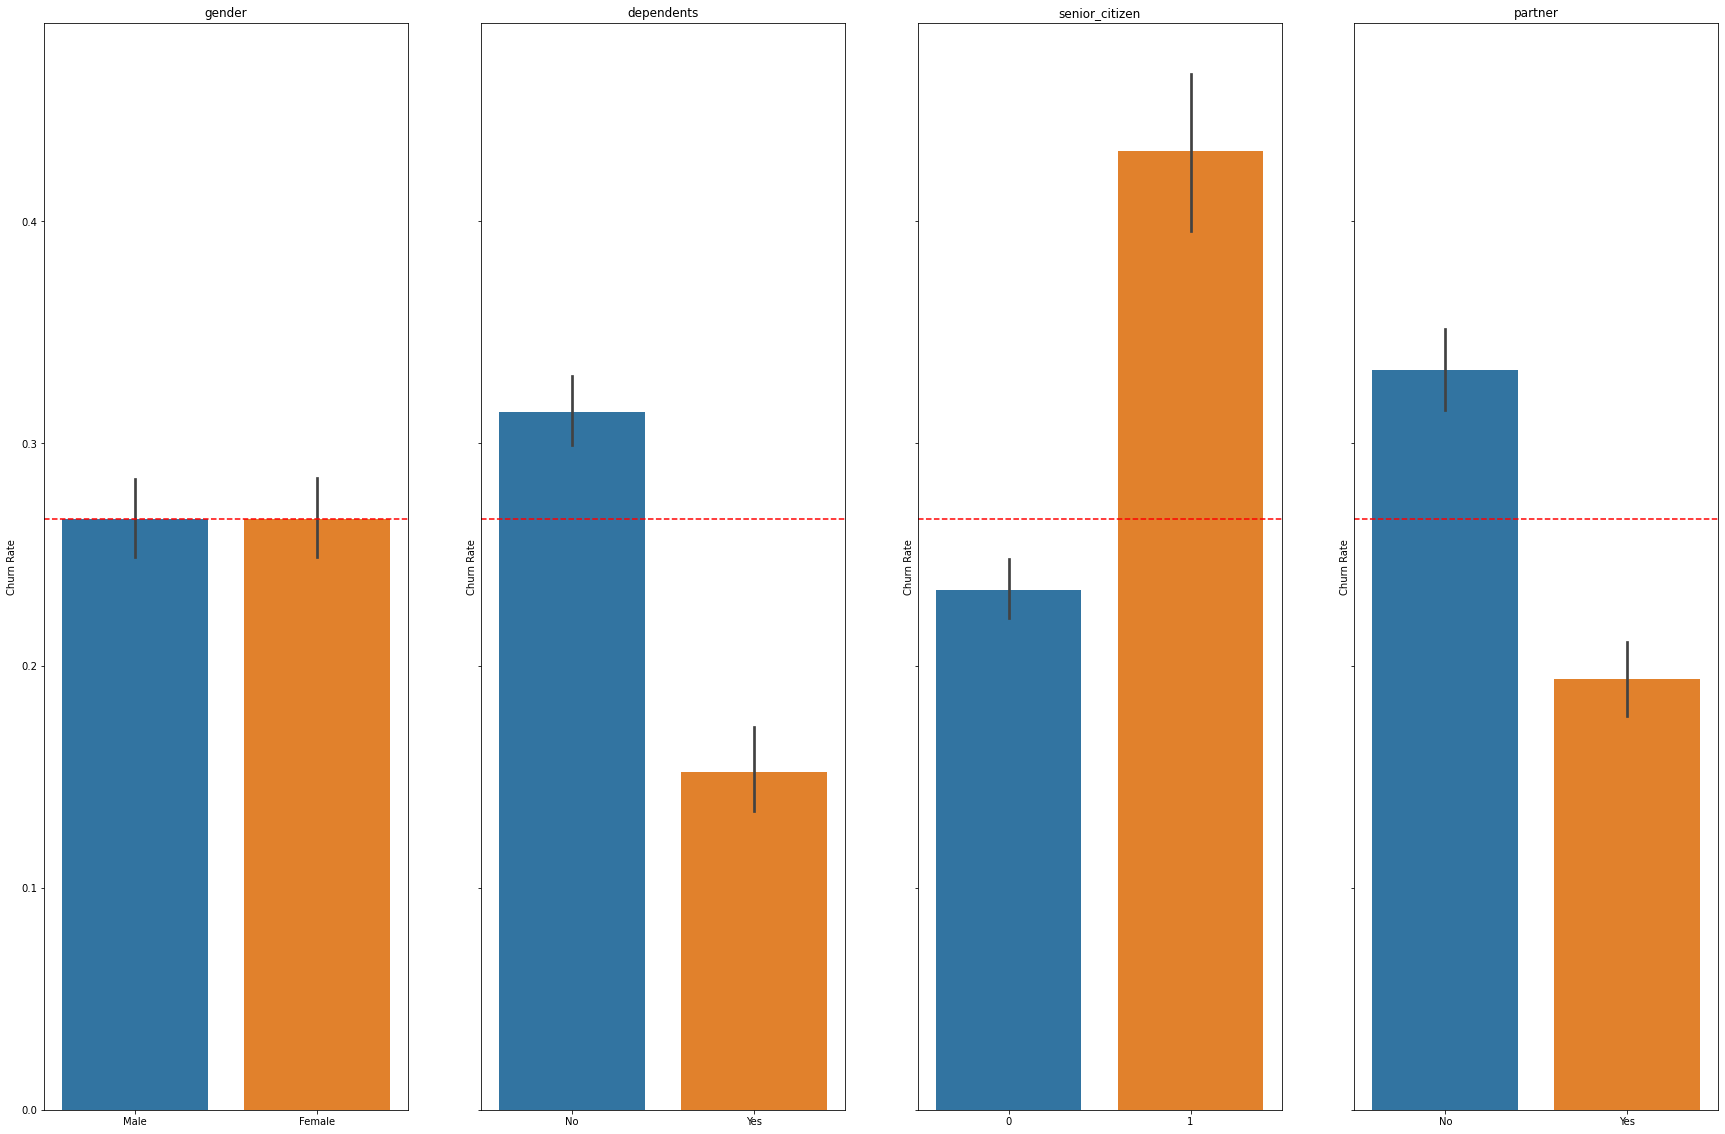

In [7]:
traits = ['gender', 'dependents', 'senior_citizen' , 'partner']
_, ax =plt.subplots(nrows = 1, ncols = 4, figsize = (30, 20), sharey = True)
for i , trait in enumerate(traits):
    sns.barplot(trait, 'churn_Yes', data = train, ax = ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(trait)
    ax[i].axhline(churn_rate, ls='--', color = 'red')

- gender doesn't appear to have an impact on churn rate
- those with dependents seem to churn less than those without dependents 
- seniors seem to churn at a much higher rate
- those without partners seem to churn higher than average

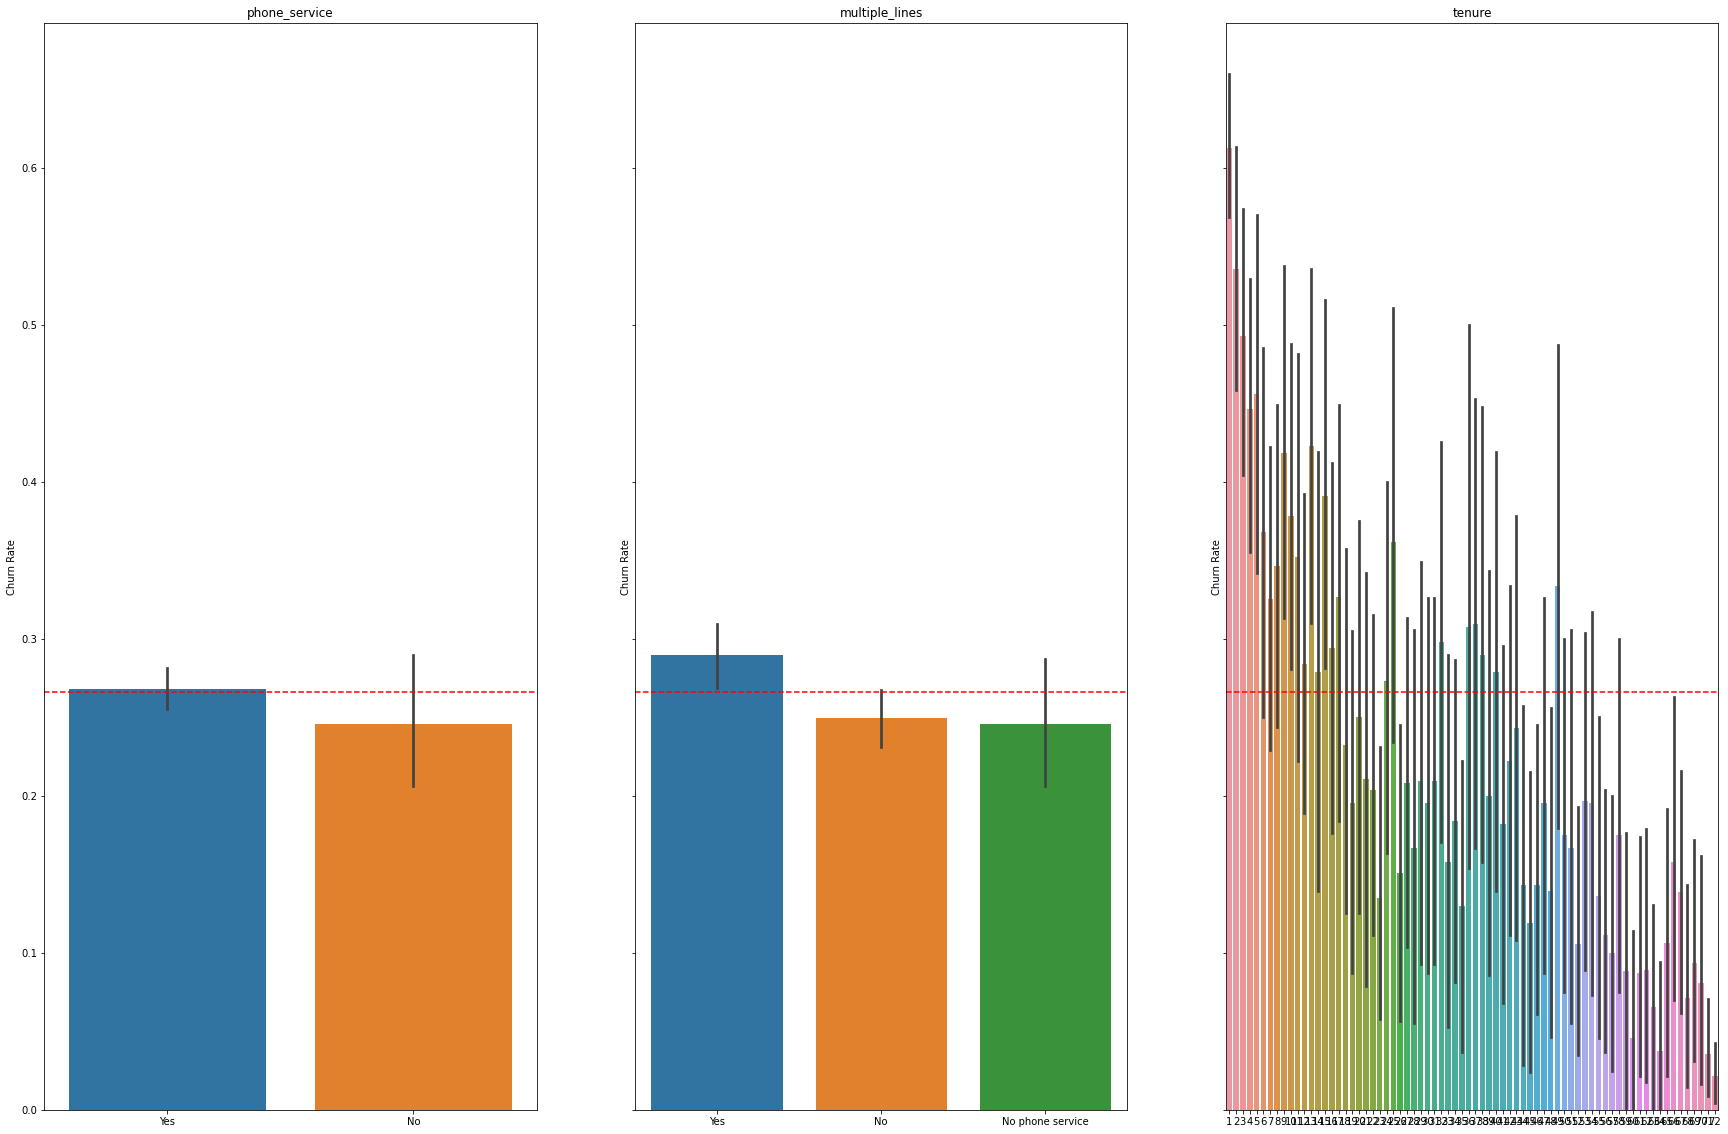

In [8]:
traits = ['phone_service', 'multiple_lines', 'tenure']
_, ax =plt.subplots(nrows = 1, ncols = 3, figsize = (30,20), sharey = True)
for i , trait in enumerate(traits):
    sns.barplot(trait, 'churn_Yes', data = train, ax = ax[i])
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Churn Rate')
    ax[i].set_title(trait)
    ax[i].axhline(churn_rate, ls='--', color = 'red')

- phone service or whether or not a person has multiple lines doesn't seem to have much of an impact
- Bin tenure in intervals of 5 months to try to get a easier to understand graph 

## Taking a deeper look at Churn as it relates to Tenure

In [9]:
train.tenure_binned.value_counts()

1 - 5      899
6 - 10     378
71+        348
66 - 70    318
11 - 15    306
16 - 20    250
61 - 65    248
21 - 25    246
51 - 55    234
31 - 35    231
26 - 30    226
46 - 50    217
56 - 60    212
41 - 45    203
36 - 40    184
Name: tenure_binned, dtype: int64

This gives us a count of people that have left by month, but getting a percentage of customers who churn by month would paint a more accurate picture

In [10]:
# have to create an order list so the graph columns appear in the correct order
order_list = ['1 - 5','6 - 10','11 - 15','16 - 20','21 - 25','26 - 30','31 - 35','36 - 40','41 - 45','46 - 50','51 - 55','56 - 60','61 - 65','66 - 70','71+']

In [11]:
tb_perc = train.groupby(['tenure_binned'])
tb_perc = round(tb_perc.mean().churn_Yes*100,2)
tb_perc

tenure_binned
1 - 5      54.51
11 - 15    34.97
16 - 20    26.00
21 - 25    23.58
26 - 30    18.58
31 - 35    19.48
36 - 40    27.72
41 - 45    18.23
46 - 50    19.35
51 - 55    15.81
56 - 60    10.38
6 - 10     36.51
61 - 65     7.66
66 - 70    10.69
71+         2.59
Name: churn_Yes, dtype: float64

- tb_perc gives us the percentage of customers that have churned by groups of months.

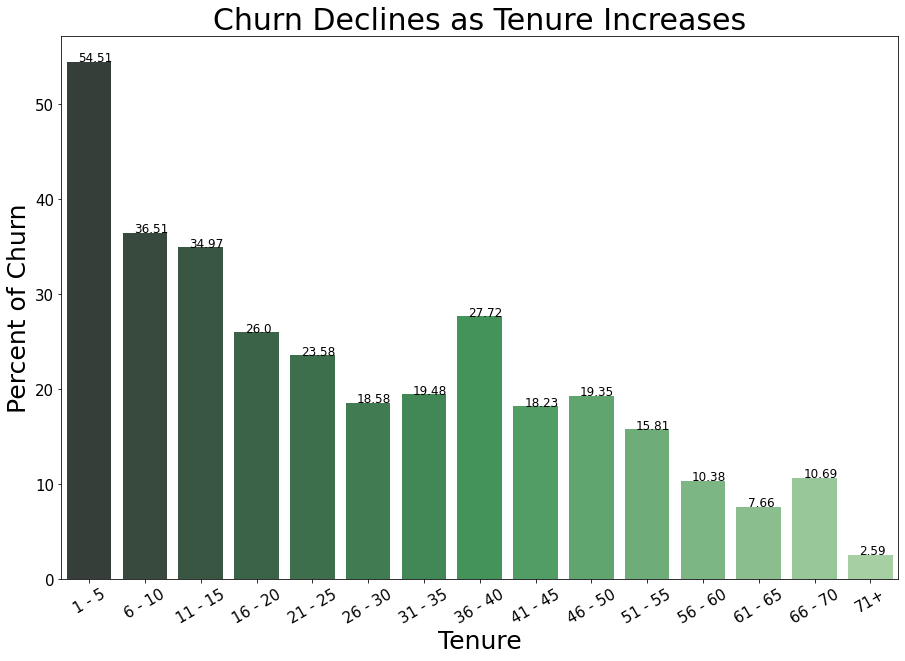

In [12]:
plt.figure(figsize = (15,10))
pal = sns.color_palette("Greens_d", len(tb_perc))
ax = sns.barplot(y= tb_perc , x = tb_perc.index, order = order_list, palette = np.array(pal[::-1]))
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title("Churn Declines as Tenure Increases", fontsize = 30)
plt.xlabel("Tenure",fontsize=25)
plt.ylabel("Percent of Churn", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=12, ha="left")

In [13]:
null_hypothesis= f'Tenure and Churn are independent of each other.'
α = .05
obs =pd.crosstab(train.tenure, train.churn)
chi2, p = stats.chi2_contingency(obs)[0:2]

chi2, p, degf, expected = stats.chi2_contingency(obs)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p > α:
    print(null_hypothesis)
else:
    print('Tenure and churn are not independent of each other')

chi^2 = 706.5346
p     = 0.0000
Tenure and churn are not independent of each other


Takeaways:
 - percentage of churn decreases as tenure increases
 - get customers past the first 5 months and rate of churn decreases by nearly 20%
 - by months 16-20, rate of churn is nearly half of what it was in the first 5 months 

## Churn as it relates to internet service types

In [14]:
# percentage of churn by internet service types
internet_perc = train.groupby(['internet_service_type'])
internet_perc = round(internet_perc.mean().churn_Yes*100,2)
internet_perc

internet_service_type
DSL            18.57
Fiber optic    42.44
None            7.39
Name: churn_Yes, dtype: float64

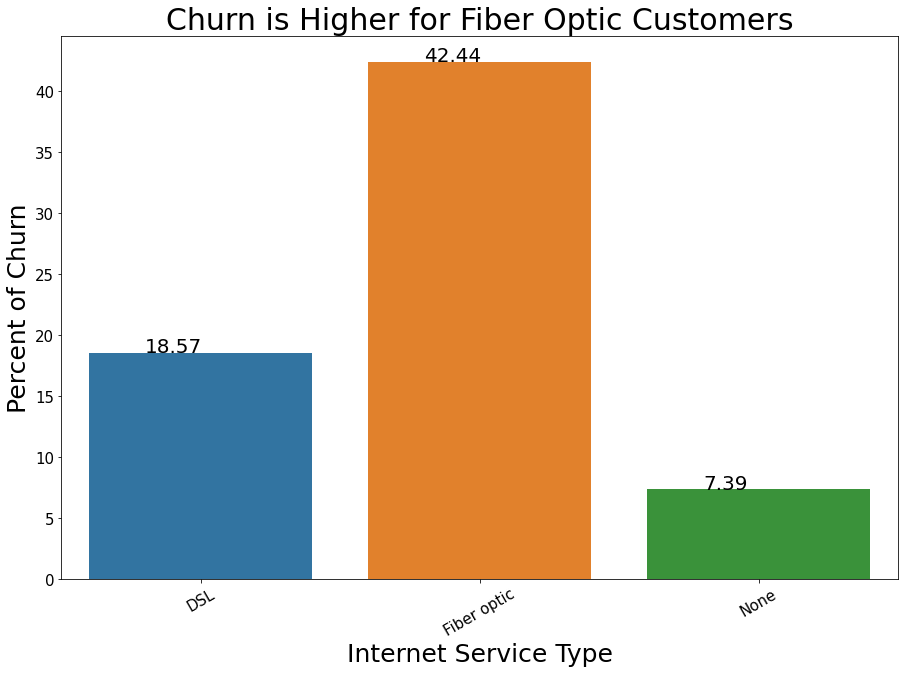

In [15]:
plt.figure(figsize = (15,10))
ax = sns.barplot(y= internet_perc , x = internet_perc.index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title("Churn is Higher for Fiber Optic Customers", fontsize = 30)
plt.xlabel("Internet Service Type",fontsize=25)
plt.ylabel("Percent of Churn", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=20, ha="left")

In [16]:
null_hypothesis= f'Internet Service Type and Churn are independent of each other.'
α = .05
obs =pd.crosstab(train.internet_service_type, train.churn)
chi2, p = stats.chi2_contingency(obs)[0:2]

chi2, p, degf, expected = stats.chi2_contingency(obs)

print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')
if p > α:
    print(null_hypothesis)
else:
    print('Internet service type and churn are not independent of each other')

chi^2 = 491.4212
p     = 0.0000
Internet service type and churn are not independent of each other


Takeaways:
- Customers with Fiber optic internet are over twice as likely to churn as those that have DSL 
- offer temporary discounts for fiber optic customers when they are attempting to leave 

## Churn as it relates to Payment Types

In [17]:
# percentage of churn by payment types
payment_perc = train.groupby(['payment_type'])
payment_perc = round(payment_perc.mean().churn_Yes*100,2)
payment_perc

payment_type
Bank transfer (automatic)    17.01
Credit card (automatic)      16.28
Electronic check             44.98
Mailed check                 18.94
Name: churn_Yes, dtype: float64

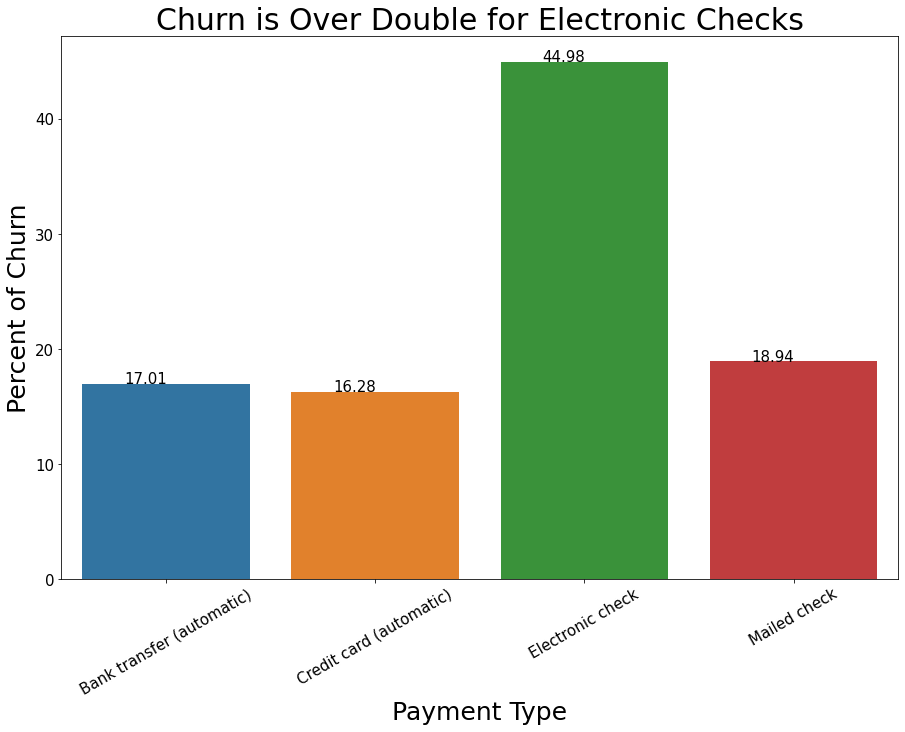

In [18]:
plt.figure(figsize = (15,10))
ax = sns.barplot(y= payment_perc , x = payment_perc.index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title("Churn is Over Double for Electronic Checks", fontsize = 30)
plt.xlabel("Payment Type",fontsize=25)
plt.ylabel("Percent of Churn", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), color='black', size=15, ha="left")

- Customers that pay by Electronic Check are drastically more likely to churn. 
- Advertise other methods of payments more than electronic checks, but we want to keep the option for electronic checks 


# SUMMARY
- Customers that stay with the company for over 5 months are over 20% less likely to leave. 
- Customers with Fiber optic internet are over twice as likely to churn as those that have DSL
- Customers that pay with electronic checks are drastically more likely to churn as those who don't 

# Modeling

# For modeling, we are going to make a second df that gets rid of columns that are objects 


In [19]:
df_original = prepare.get_telco_data()
df = df_original.copy()
df2 = prepare.model_telco_data(df)
df2 = df2.select_dtypes(exclude=['object'])
df2 = df2.rename(columns={'churn_Yes': 'churn'})
df2.head()

,senior_citizen,tenure,monthly_charges,total_charges,gender_Male,partner_Yes,dependents_Yes,phone_service_Yes,paperless_billing_Yes,churn,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0,9,65.6,593.30,0,1,1,1,1,0,...,1,0,0,1,0,0,0,0,0,1
1,0,9,59.9,542.40,1,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,4,73.9,280.85,1,0,0,1,1,1,...,0,0,0,0,0,1,0,0,1,0
3,1,13,98.0,1237.85,1,1,0,1,1,1,...,1,0,1,0,0,1,0,0,1,0
4,1,3,83.9,267.40,0,1,0,1,1,1,...,1,0,0,0,0,1,0,0,0,1


### we will divide the data into train, validate, test

In [20]:
train_validate, test = train_test_split(df2, test_size= .2, 
                                                    random_state= 123, 
                                                    stratify=df2.churn)
train, validate = train_test_split(train_validate, test_size= .3, 
                                                            random_state= 123, 
                                                            stratify= train_validate.churn)

In [21]:
X_train = train.drop(columns=["churn"])
y_train = train.churn

X_validate = validate.drop(columns=["churn"])
y_validate = validate.churn

X_test = test.drop(columns=["churn"])
y_test = test.churn

- now that the data divided, we can move onto modeling!

### We will also go ahead and establish a baseline that we can use later on! This is a model that predicts no churn.

In [22]:
train.churn.value_counts()

0    2891
1    1046
Name: churn, dtype: int64

In [23]:
baseline = 1 - train.churn.mean()
baseline

0.7343154686309372

# Decision Trees

In [24]:
for i in range(1, 21):
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)
    tree = tree.fit(X_train, y_train)
    y_predictions = tree.predict(X_train)

    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

Tree with max depth of 1
                     0       1  accuracy    macro avg  weighted avg
precision     0.734315     0.0  0.734315     0.367158      0.539219
recall        1.000000     0.0  0.734315     0.500000      0.734315
f1-score      0.846807     0.0  0.734315     0.423404      0.621824
support    2891.000000  1046.0  0.734315  3937.000000   3937.000000

Tree with max depth of 2
                     0            1  accuracy    macro avg  weighted avg
precision     0.808605     0.707231  0.794006     0.757918      0.781672
recall        0.942580     0.383365  0.794006     0.662973      0.794006
f1-score      0.870468     0.497210  0.794006     0.683839      0.771299
support    2891.000000  1046.000000  0.794006  3937.000000   3937.000000

Tree with max depth of 3
                     0            1  accuracy    macro avg  weighted avg
precision     0.808605     0.707231  0.794006     0.757918      0.781672
recall        0.942580     0.383365  0.794006     0.662973      0.794006

## The accuracy goes higher as the max depth of the decision trees grows, so we will compare it to out of sample data and find the difference

In [25]:
metrics = []

for i in range(1, 20):

    tree = DecisionTreeClassifier(max_depth=i, random_state=123)


    tree = tree.fit(X_train, y_train)


    in_sample_accuracy = tree.score(X_train, y_train)
    
    out_of_sample_accuracy = tree.score(X_validate, y_validate)

    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy
    }
    
    metrics.append(output)
    
df = pd.DataFrame(metrics)
df["difference"] = df.train_accuracy - df.validate_accuracy
df

,max_depth,train_accuracy,validate_accuracy,difference
0,1,0.734315,0.734005,0.000311
1,2,0.794006,0.776066,0.017939
2,3,0.794006,0.776066,0.017939
3,4,0.800610,0.777844,0.022766
4,5,0.806960,0.776066,0.030893
5,6,0.817374,0.779621,0.037753
6,7,0.832868,0.762441,0.070427
7,8,0.843282,0.765995,0.077286
8,9,0.860046,0.764810,0.095235
9,10,0.879350,0.757109,0.122241


### When compared to out of sample data, we see that the differences grow drastically. So even though a max depth of 19 gives an accuracy of 99% in the train data, it only gives a 72% accuracy when in validate

### - We are still, however, talking about churn. This means that we could afford to have false positives. So we don't waste resources too much, I would recommend a max depth of 4. This still gives us an 80% success rate in identifying those who churn, but keeps us from spending too much time on customers who aren't at rist of churning. 

### Comparing this against the test set, we can see that the results are about the same as they were with the validate. I would change my recommendation is to go to a max depth of 9, though, if we are able to expend the resources. 

### Takeaways
- We have a model that can correctly identify customers that are going to churn 99% of the time so that we can contact those customers to try to prevent them from churning.

# Random Forest Modeling

- After running a few different random forest tests, i settled on doing a max depth of 10 with a minimum sample leaf of 3 and 150 estimators

In [26]:
# on train
rf10 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=150,
                            max_depth=10, 
                            random_state=123)
rf10.fit(X_train, y_train)
y_pred = rf10.predict(X_train)
y_pred_proba = rf10.predict_proba(X_train)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf10.score(X_train, y_train)))
print(classification_report(y_train , y_pred))

Accuracy of random forest classifier on training set: 0.86
              precision    recall  f1-score   support

           0       0.87      0.94      0.91      2891
           1       0.79      0.63      0.70      1046

    accuracy                           0.86      3937
   macro avg       0.83      0.78      0.80      3937
weighted avg       0.85      0.86      0.85      3937



- This left me with an 86% accuracy and a 63% recall on my train data

#### validate the model

In [27]:
# on validate
rf10 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=150,
                            max_depth=10, 
                            random_state=123)
rf10.fit(X_validate, y_validate)
y_pred = rf10.predict(X_validate)
y_pred_proba = rf10.predict_proba(X_validate)
print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf10.score(X_validate, y_validate)))
print(classification_report(y_validate , y_pred))

Accuracy of random forest classifier on validate set: 0.88
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1239
           1       0.86      0.65      0.74       449

    accuracy                           0.88      1688
   macro avg       0.87      0.81      0.83      1688
weighted avg       0.88      0.88      0.87      1688



- this brings back a 88% accuracy as well as a 65% recall for the validate set. 

#### Test the model

In [28]:
#on test
rf10 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=150,
                            max_depth=10, 
                            random_state=123)
rf10 = rf10.fit(X_test, y_test)
y_pred = rf10.predict(X_test)
y_forest_proba = rf10.predict_proba(X_test)
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf10.score(X_test, y_test)))
print(classification_report(y_test , y_pred))

Accuracy of random forest classifier on test set: 0.89
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1033
           1       0.88      0.69      0.77       374

    accuracy                           0.89      1407
   macro avg       0.89      0.83      0.85      1407
weighted avg       0.89      0.89      0.89      1407



- the test model brings back an 89% accuracy and almost a 69% recall

## Modeling using KNN

In [29]:
knn3 = KNeighborsClassifier(n_neighbors=3, weights='uniform')
knn3.fit(X_train, y_train)
y_pred = knn3.predict(X_train)
y_pred_proba = knn3.predict_proba(X_train)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn3.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.86


In [30]:
pd.crosstab(y_train, y_pred)

col_0,0,1
churn,,
0,2689,202
1,358,688


In [31]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      2891
           1       0.77      0.66      0.71      1046

    accuracy                           0.86      3937
   macro avg       0.83      0.79      0.81      3937
weighted avg       0.85      0.86      0.85      3937



In [32]:
print('Accuracy of KNN on training set: {:.2f}'
     .format(knn3.score(X_train, y_train)))

print('F1 score of KNN on training set: {:.2f}'
     .format(f1_score(y_train, y_pred)))

recall_knn = 688/(688+358)

print('Recall of KNN on training set: {:.2f}'
     .format(recall_knn))

Accuracy of KNN on training set: 0.86
F1 score of KNN on training set: 0.71
Recall of KNN on training set: 0.66


- With an accuracy of the KNN being 86% and the recall being 66%, it is outperformed by the random forest. 

### Takeaways: 
- The random forest model brings back a decent recall as well as a good accuracy. In the test set, the random forest model returned an 89% accuracy as well as a 69% recall.
- If we were to move forward with a model, I would recommend the random forest model. Even though there is the risk of contacting persons that weren't going to churn, it is better to contact them than to not contact someone who was going to churn.

# Final Model
 - Create predictions data frame that is based off of my random forest model and store it to a csv

In [33]:
best_model = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=150,
                            max_depth=10, 
                            random_state=123)
best_model = best_model.fit(X_test, y_test)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)
y_proba = y_proba[:,1]
predictions = pd.DataFrame({
    "index" : test.index, 
    "prediction": y_pred,
    "probability_of_churn": y_proba
})
predictions.sort_values(by='probability_of_churn', ascending = False, inplace = True)
predictions.to_csv('predictions.csv', index = False)

# Conclusion
There are a few things that can be driving churn among our customers. 

Some of the things that influence churn are: 
   - Internet Service Type
   - How long the customer has been with the company
   - The payment type the customer uses

To reduce churn, we can:
   - Offer specials during the first 6 months of a person's contract
   - Advertise our DSL internet over our fiber optic product
   - Push forms of payment methods other than electronic checks
   - Advertise to younger customers more than senior citizens
   
With additional time dedicated to this project: 
   - Find driving forces of churn among the customers that are leaving in the first 5 months
   - Investigate the cost of fiber optic internet over DSL
   - Incorporate other machine learning techniques
   